## Energy Management Model

### Problem

We consider a network consisting of $N$ nodes and $M$ edges over a horizon of $T$ timesteps.  
We want to maximize the sum of state of charges across all nodes at the last 
timestep while minimizing charge/discharge rates.  
We need to satisfy some physical and operational constraints.

### Variables

- **State of charge \( $q \in \mathcal{R}^{N \times T}_{+}$ \)**
- **Charge/discharge \( $c \in \mathcal{R}^{N \times T}$ \)**
- **Power flow \( $f \in \mathcal{R}^{N \times T}$ \)**
- **Renewable slack \( $\tilde r \in \mathcal{R}^{N \times T}_{+}$ \)**: The slack variable for renewable energy generation.

### Data

- **Renewable energy \( $r \in \mathcal{R}^{N \times T}$ \)**
- **Non-renewable energy \( $g \in \mathcal{R}^{N \times T}$ \)**
- **Load \( $l \in \mathcal{R}^{N \times T}$ \)**
- **Adjacency matrix \( $A \in \mathcal{R}^{N \times N}$ \)**: It is symmetric and has $0$ in diagonal entries.

### Constraints

The model incorporates several constraints to ensure physical and operational limits:

- **Charging dynamics**: 
  $$q_{t+1} = q_{t} + c_{t} \quad \text{for } t = 1, \ldots, T-1.$$
- **Initial conditions**: 
  $$q_{1} = q^{\text{init}} \quad \text{and} \quad c_{1} = c^{\text{init}}.$$
- **Charge/discharge limits**: 
  $$|c_{t}| \leq C \quad \text{for } t = 1, \ldots, T.$$
- **Flow limits**: 
  $$|f_{t}| \leq F \quad \text{for } t = 1, \ldots, T.$$
- **State of charge limits**: 
  $$0 \leq q_{t} \leq Q \quad \text{for } t = 1, \ldots, T.$$
- **Renewable generation limits**: 
  $$0 \leq \tilde r_{t} \leq r_{t} \quad \text{for } t = 1, \ldots, T.$$
- **Conservation of flow (i.e. Kirchoff)**: 
  $$A f_{t} - c_{t} + \tilde r_{t} + g_{t} - l_{t} = 0 \quad \text{for } t = 1, \ldots, T.$$

### Objective

The objective is to maximize the final states of charge across all nodes while minimizing 
the regularization of charge/discharge activities, formulated as:
$$\min \left(-\sum_{n=1}^N q_{n,T} + \lambda \sum_{n=1}^N \sum_{t=1}^{T} |c_{n,t}|\right)$$
where $\lambda$ is a hyperparameter.

### Numerical Experiments

Next, we demonstrate our energy management model using real-world data.  
The simulations are conducted on a network consisting of three nodes representing the PJM, ERCOT, and CAISO grids.  
It is over a period from April 1, 2023, at 00:00 UTC to April 3, 2023, at 23:00 UTC.

#### Model parameters
- **Nodes (N)**: 3 (PJM, ERCOT, CAISO)
- **Time Steps (T)**: 72 hours
- **Edges (M)**: 3 (each node is bidirectionally connected to each other)

#### Data setup
- **Data retrieval**: Data matrices $r$, $g$, and $l$ for renewable energy, non-renewable energy, and load, respectively.  
They are retrieved from the GridStatus API for each of the three nodes.
- **Period**: Data spans from April 1, 2023, 00:00 UTC to April 3, 2023, 23:00 UTC, providing an hourly update over 72 hours.

#### Simulation Setup
- **Flow limit \( F \)**: 5000 MW for each node.
- **Charge/discharge limit \( C \)**: 150 MW for each node.
- **State of charge limit \( Q \)**: 10000 MWh for each node.
- **Regularization parameter \( $\lambda$ \)**: Set at 0.1 to balance maximizing the state of charge and minimizing charge/discharge activities.
- **Adjacency matrix \( A \)**: Defined as symmetric with zero diagonal entries, signifying no self-loops and uniform connectivity among the nodes.

These parameters and data sets provide a realistic framework for testing  
the energy management model's effectiveness under typical operational conditions of a multi-node power grid.  
Note that this is a first cut attempt.



## Environment setup and graph visualization

This notebook sets up the necessary environment for managing and analyzing energy data across a network of nodes.  
We use various Python libraries such as Pandas for data manipulation, Matplotlib for plotting, and CVXPY for optimization.  
The `GridStatusClient` from `gridstatusio` is initialized with an API key to fetch real-time grid status data, facilitating detailed energy management simulations.  
Then, we visualize the network as a graph.


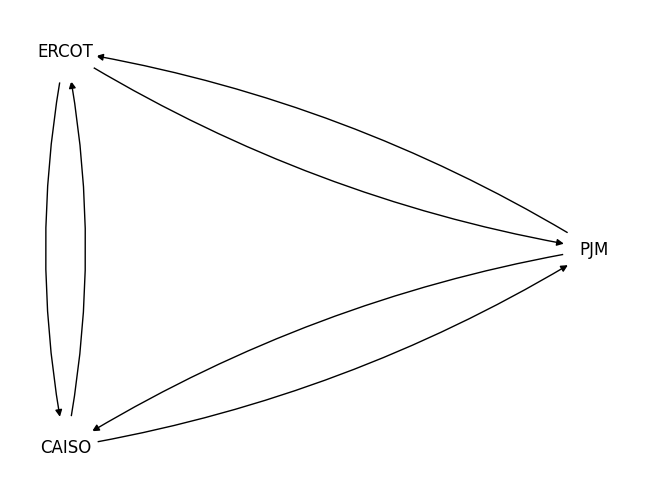

In [1]:
from gridstatusio import GridStatusClient
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import cvxpy as cp
import numpy as np
import networkx as nx
client = GridStatusClient(api_key="5168efed964a4985800f60a3bc1c2581")
# Create a graph
G = nx.DiGraph()
labels = {1: 'PJM', 2: 'ERCOT', 3: 'CAISO'}
G.add_nodes_from(labels.keys())
edges = [(1, 2), (2, 1), (2, 3), (3, 2), (1, 3), (3, 1)]
G.add_edges_from(edges)
pos = nx.circular_layout(G)
nx.draw(G, pos, node_color='white', edge_color='black', node_size=2000,
        with_labels=False, arrows=True, connectionstyle='arc3,rad=0.1')
nx.draw_networkx_labels(G, pos, labels, font_size=12)
#plt.savefig('network_graph.pdf')
plt.show()


### Data retrieval and processing

This section of the notebook demonstrates how to retrieve and process energy data from the GridStatus API for the PJM, ERCOT, and CAISO grids over a specified period.  
The data includes fuel mix and load metrics.

#### Data retrieval

We retrieve the following datasets for the period from April 1, 2023, to April 4, 2023:
- **PJM Fuel Mix**
- **PJM Load**
- **ERCOT Fuel Mix**
- **ERCOT Load**
- **CAISO Fuel Mix**
- **CAISO Load**

These datasets are accessed using the `GridStatusClient`, with the API key provided.  
Each dataset includes various energy sources and total load values recorded over the period.

#### Data processing

For each grid (PJM, ERCOT, CAISO), the steps are as follows:
1. Convert the 'interval_start_utc' column to datetime format.
2. Set this datetime column as the index for each dataframe.
3. Resample the data to an hourly frequency using the mean to standardize the time series.

#### Variables created

- **Load arrays**: Numpy arrays for hourly load data for each grid.
- **Fuel mix arrays**: Numpy arrays for each type of fuel used within the grids.  
This includes renewables and non-renewables like solar, wind, coal, gas, hydro, and others depending on the grid.

#### Calculation of renewable and non-renewable energy totals

For each grid, we calculate the total renewable and non-renewable energy for every hour by summing the appropriate columns:
- **Renewables**: Sum of all renewable energy sources like solar, wind, hydro, and others depending on availability in the dataset.
- **Non-renewables**: Sum of all non-renewable energy sources like coal, natural gas, nuclear, and others.

### Example of usage

For PJM:
- Renewable energy is calculated as the sum of solar, wind, other renewables, hydro, and storage.
- Non-renewable energy is calculated as the sum of coal, gas, multiple fuels, nuclear, and oil.



In [2]:

pjm_fuel_mix = client.get_dataset(dataset="pjm_fuel_mix",start="2023-04-01",end="2023-04-04")
pjm_load = client.get_dataset(dataset="pjm_load",start="2023-04-01",end="2023-04-04")
pjm_fuel_mix['interval_start_utc'] = pd.to_datetime(pjm_fuel_mix['interval_start_utc'])
pjm_load['interval_start_utc'] = pd.to_datetime(pjm_load['interval_start_utc'])
pjm_fuel_mix.set_index('interval_start_utc', inplace=True)
pjm_load.set_index('interval_start_utc', inplace=True)
hourly_fuel_mix = pjm_fuel_mix[['solar', 'wind', 'other_renewables', 'coal', 'gas', 'hydro', 'multiple_fuels', 'nuclear', 'oil', 'storage']].resample('H').mean()
hourly_load = pjm_load['load'].resample('H').mean()
# Convert to numpy arrays
l_pjm = hourly_load.to_numpy()
s_pjm = hourly_fuel_mix['solar'].to_numpy()
w_pjm = hourly_fuel_mix['wind'].to_numpy()
other_pjm = hourly_fuel_mix['other_renewables'].to_numpy()
c_pjm = hourly_fuel_mix['coal'].to_numpy()
g_pjm = hourly_fuel_mix['gas'].to_numpy()
h_pjm = hourly_fuel_mix['hydro'].to_numpy()
mf_pjm = hourly_fuel_mix['multiple_fuels'].to_numpy()
n_pjm = hourly_fuel_mix['nuclear'].to_numpy()
storage_pjm = hourly_fuel_mix['storage'].to_numpy()
o_pjm = hourly_fuel_mix['oil'].to_numpy()

renewables_pjm = s_pjm+w_pjm+h_pjm+storage_pjm+other_pjm
non_renewables_pjm = c_pjm+g_pjm+mf_pjm+n_pjm+o_pjm

ercot_fuel_mix = client.get_dataset(dataset="ercot_fuel_mix",start="2023-04-01",end="2023-04-04")
ercot_load = client.get_dataset(dataset="ercot_load",start="2023-04-01",end="2023-04-04")
ercot_fuel_mix['interval_start_utc'] = pd.to_datetime(ercot_fuel_mix['interval_start_utc'])
ercot_load['interval_start_utc'] = pd.to_datetime(ercot_load['interval_start_utc'])
ercot_fuel_mix.set_index('interval_start_utc', inplace=True)
ercot_load.set_index('interval_start_utc', inplace=True)
hourly_fuel_mix = ercot_fuel_mix[['solar', 'wind', 'coal_and_lignite', 'natural_gas', 'hydro', 'nuclear', 'power_storage', 'other']].resample('H').mean()
hourly_load = ercot_load['load'].resample('H').mean()
# Convert to numpy arrays
l_ercot = hourly_load.to_numpy()
s_ercot = hourly_fuel_mix['solar'].to_numpy()
w_ercot = hourly_fuel_mix['wind'].to_numpy()
c_ercot = hourly_fuel_mix['coal_and_lignite'].to_numpy()
g_ercot = hourly_fuel_mix['natural_gas'].to_numpy()
h_ercot = hourly_fuel_mix['hydro'].to_numpy()
n_ercot = hourly_fuel_mix['nuclear'].to_numpy()
storage_ercot = hourly_fuel_mix['power_storage'].to_numpy()
o_ercot = hourly_fuel_mix['other'].to_numpy()

renewables_ercot = s_ercot+w_ercot+h_ercot+storage_ercot
non_renewables_ercot = c_ercot+g_ercot+n_ercot+o_ercot

caiso_fuel_mix = client.get_dataset(dataset="caiso_fuel_mix",start="2023-04-01",end="2023-04-04")
caiso_load = client.get_dataset(dataset="caiso_load",start="2023-04-01",end="2023-04-04")
caiso_fuel_mix['interval_start_utc'] = pd.to_datetime(caiso_fuel_mix['interval_start_utc'])
caiso_load['interval_start_utc'] = pd.to_datetime(caiso_load['interval_start_utc'])
caiso_fuel_mix.set_index('interval_start_utc', inplace=True)
caiso_load.set_index('interval_start_utc', inplace=True)
hourly_fuel_mix = caiso_fuel_mix[['solar', 'wind', 'biomass', 'biogas', 'geothermal', 'small_hydro', 'large_hydro', 'coal', 'natural_gas', 'nuclear', 'batteries', 'imports', 'other']].resample('H').mean()
hourly_load = caiso_load['load'].resample('H').mean()
# Convert to numpy arrays
l_caiso = hourly_load.to_numpy()
s_caiso = hourly_fuel_mix['solar'].to_numpy()
w_caiso = hourly_fuel_mix['wind'].to_numpy()
b_caiso = hourly_fuel_mix['biomass'].to_numpy()
bg_caiso = hourly_fuel_mix['biogas'].to_numpy()
geo_caiso = hourly_fuel_mix['geothermal'].to_numpy()
sh_caiso = hourly_fuel_mix['small_hydro'].to_numpy()
lh_caiso = hourly_fuel_mix['large_hydro'].to_numpy()
c_caiso = hourly_fuel_mix['coal'].to_numpy()
g_caiso = hourly_fuel_mix['natural_gas'].to_numpy()
n_caiso = hourly_fuel_mix['nuclear'].to_numpy()
storage_caiso = hourly_fuel_mix['batteries'].to_numpy()
imports_caiso = hourly_fuel_mix['imports'].to_numpy()
o_caiso = hourly_fuel_mix['other'].to_numpy()

renewables_caiso = s_caiso+w_caiso+b_caiso+bg_caiso+geo_caiso+sh_caiso+lh_caiso+storage_caiso+imports_caiso
non_renewables_caiso = c_caiso+g_caiso+n_caiso+o_caiso


Fetching Page 1...Done in 0.52 seconds. 

Total number of rows: 864
Fetching Page 1...Done in 0.61 seconds. 

Total number of rows: 864
Fetching Page 1...Done in 0.41 seconds. 

Total number of rows: 861
Fetching Page 1...Done in 0.21 seconds. 

Total number of rows: 864
Fetching Page 1...Done in 0.46 seconds. 

Total number of rows: 864
Fetching Page 1...Done in 0.4 seconds. 

Total number of rows: 864


### Visualization of Load and Energy Sources

This section of the code generates visualizations for the load, renewable, and non-renewable energy data for three major grids: PJM, ERCOT, and CAISO.  
Each grid's data is plotted over the period from April 1, 2023, to April 3, 2023.

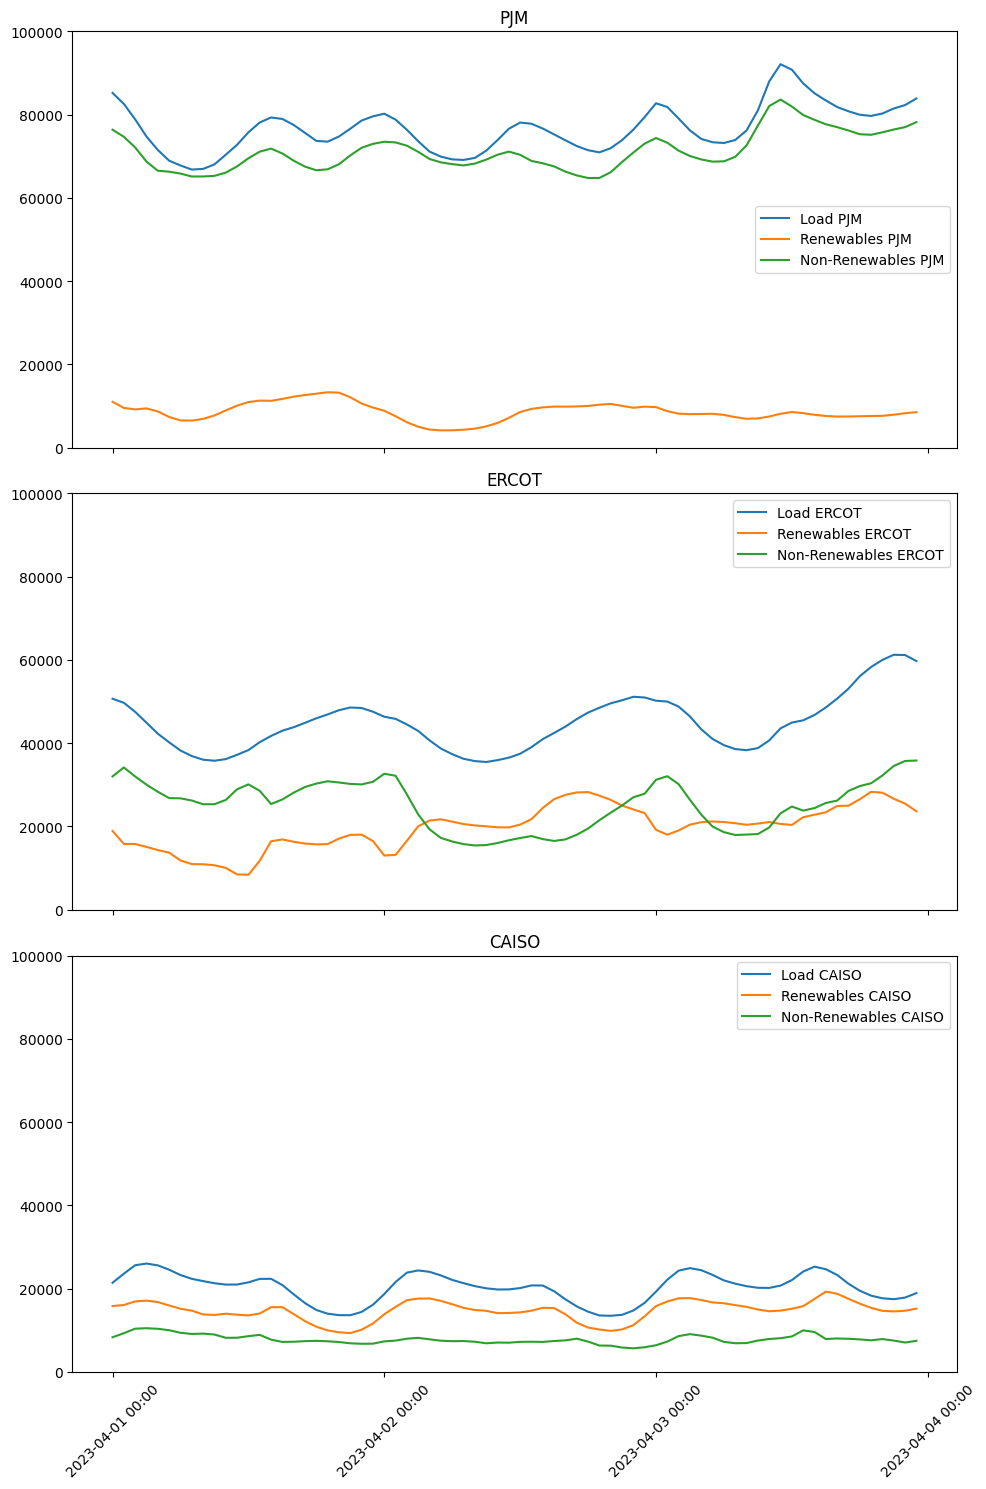

In [3]:
# Generate a date range for the x-axis
date_range = pd.date_range(start="2023-04-01 00:00", end="2023-04-03 23:00", freq='H')
fig, axs = plt.subplots(3, 1, sharex=True, sharey=True, figsize=(10, 15))
# Plotting for PJM
axs[0].plot(date_range, l_pjm, label="Load PJM")
axs[0].plot(date_range, renewables_pjm, label="Renewables PJM")
axs[0].plot(date_range, non_renewables_pjm, label="Non-Renewables PJM")
axs[0].set_ylim([0, 100000])
axs[0].legend()
axs[0].set_title("PJM")
# Plotting for ERCOT
axs[1].plot(date_range, l_ercot, label="Load ERCOT")
axs[1].plot(date_range, renewables_ercot, label="Renewables ERCOT")
axs[1].plot(date_range, non_renewables_ercot, label="Non-Renewables ERCOT")
axs[1].set_ylim([0, 100000])
axs[1].legend()
axs[1].set_title("ERCOT")
# Plotting for CAISO
axs[2].plot(date_range, l_caiso, label="Load CAISO")
axs[2].plot(date_range, renewables_caiso, label="Renewables CAISO")
axs[2].plot(date_range, non_renewables_caiso, label="Non-Renewables CAISO")
axs[2].set_ylim([0, 100000])
axs[2].legend()
axs[2].set_title("CAISO")
# Formatting x-axis
axs[2].xaxis.set_major_locator(mdates.DayLocator())
axs[2].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
plt.xticks(rotation=45)
plt.tight_layout()  # Adjust layout to not overlap
plt.savefig('load_renewables_nonrenewables.pdf')  # Save as PDF
plt.show()


### Visualization of demand and supply

Next, we combine renewable and non-renewable generation as supply and show load as demand,  
we plot supply-demand curves for each node.


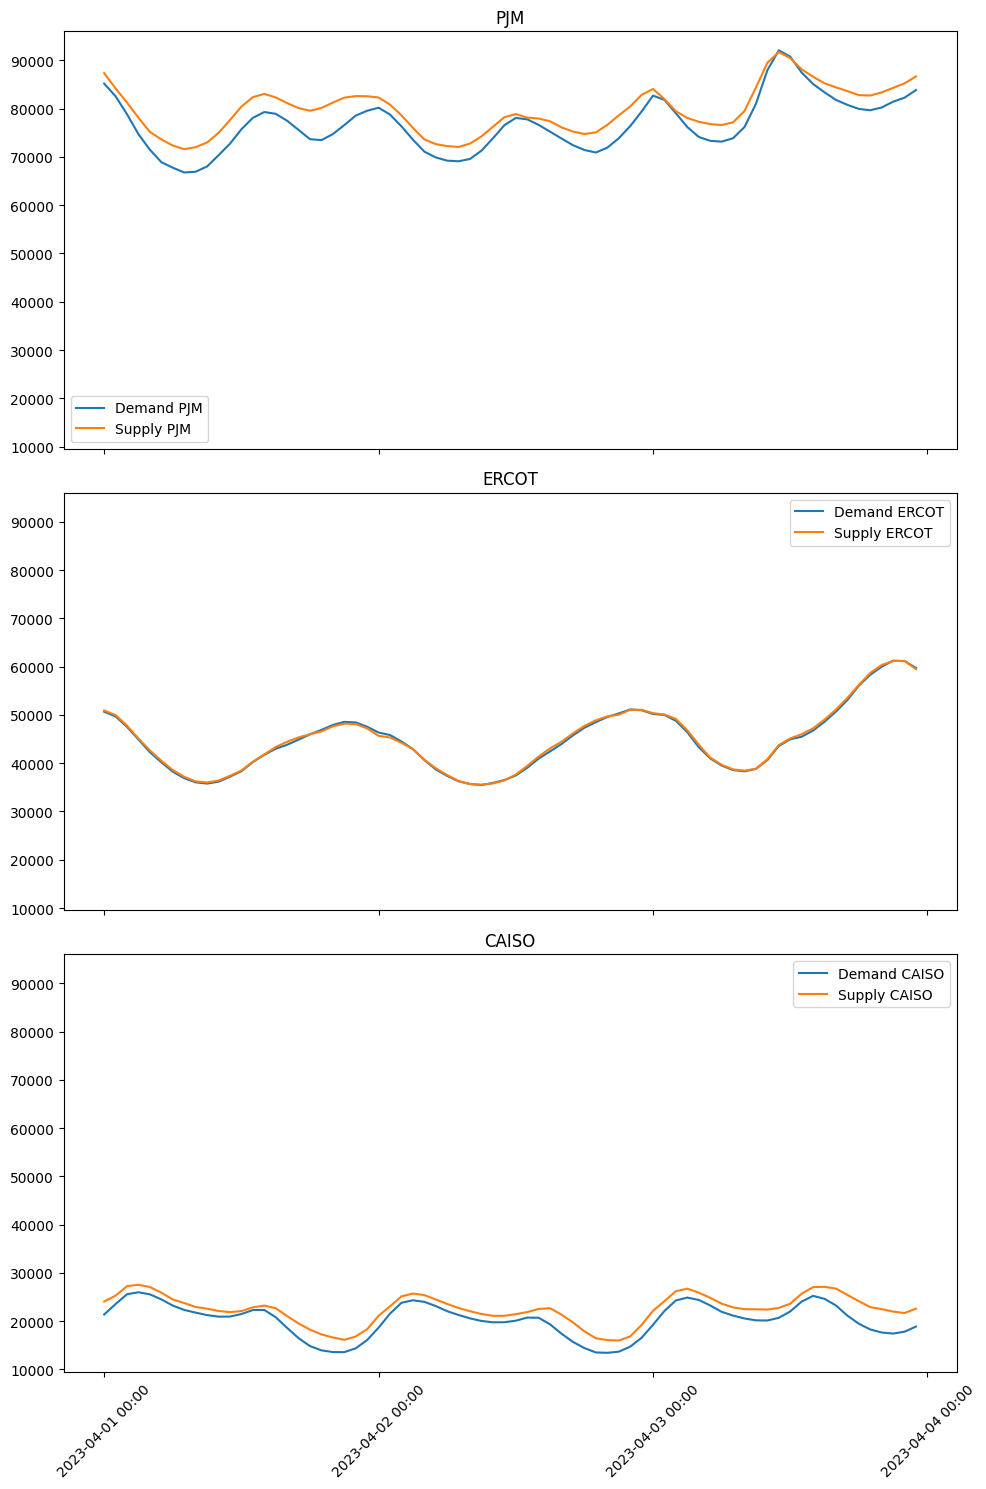

In [4]:
# Generate a date range for the x-axis
date_range = pd.date_range(start="2023-04-01 00:00", end="2023-04-03 23:00", freq='H')
fig, axs = plt.subplots(3, 1, sharex=True, sharey=True, figsize=(10, 15))
# Plotting for PJM
axs[0].plot(date_range, l_pjm, label="Demand PJM")
axs[0].plot(date_range, renewables_pjm + non_renewables_pjm, label="Supply PJM")
axs[0].legend()
axs[0].set_title("PJM")
# Plotting for ERCOT
axs[1].plot(date_range, l_ercot, label="Demand ERCOT")
axs[1].plot(date_range, renewables_ercot + non_renewables_ercot, label="Supply ERCOT")
axs[1].legend()
axs[1].set_title("ERCOT")
# Plotting for CAISO
axs[2].plot(date_range, l_caiso, label="Demand CAISO")
axs[2].plot(date_range, renewables_caiso + non_renewables_caiso, label="Supply CAISO")
axs[2].legend()
axs[2].set_title("CAISO")
# Formatting x-axis
axs[2].xaxis.set_major_locator(mdates.DayLocator())
axs[2].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
plt.xticks(rotation=45)
plt.tight_layout()  # Adjust layout to not overlap
plt.savefig('supply_demand.pdf')  # Save as PDF
plt.show()


### Implementation of the energy management model

The Python script outlined below sets up and solves an optimization problem for energy management across three interconnected nodes representing the PJM, ERCOT, and CAISO grids.  
The model focuses on optimizing the state of charge at each node while adhering to operational constraints over a three-day period.

#### Model setup

- **Nodes (N)**: 3, representing PJM, ERCOT, and CAISO.
- **Time steps (T)**: 72, covering hourly intervals from April 1, 2023, to April 3, 2023.
- **Variables**:
  - $q$: State of charge for each node over time.
  - $c$: Charge/discharge rates for each node over time.
  - $f$: Power flows between nodes over time.
  - $\tilde{r}$: Slack variables for managing renewables at each node.
- **Data**:
  - Renewable and non-renewable energy sources, and load data, are structured into matrices for each node and time step.
- **Constraints**:
  - Dynamic constraints for state of charge based on previous state and charge/discharge actions.
  - Physical limits for charge/discharge activities and power flow.
  - Conservation laws ensuring that the energy within the network is balanced.
- **Objective**:
  - Minimize the negative sum of the final states of charge across all nodes adjusted by a regularization term for the charge/discharge activities.

#### Numerical solution

- The problem is formulated and solved using `cvxpy` with the MOSEK solver.
- The results include optimized state of charge, charge/discharge rates, and power flows.


In [5]:
N = 3 #number of nodes
T = 72 # number of time steps
q = cp.Variable((N,T)) # state of charge of battery at each node variable
c = cp.Variable((N,T)) # charge/discharge variable
r_tilde = cp.Variable((N,T)) # renewables slack variable
f = cp.Variable((N,T)) # flow variable
r = np.hstack([non_renewables_pjm.reshape(-1,1),non_renewables_ercot.reshape(-1,1),non_renewables_caiso.reshape(-1,1)]).T # renewables data
g = np.hstack([renewables_pjm.reshape(-1,1),renewables_ercot.reshape(-1,1),renewables_caiso.reshape(-1,1)]).T # non-renewables data
l = np.hstack([l_pjm.reshape(-1,1),l_ercot.reshape(-1,1),l_caiso.reshape(-1,1)]).T # load data
C = 150*np.ones((N,)) # charge/discharge limits-time independent
F = 5000*np.ones((N,)) #  flow limits-time independent
Q = 10000*np.ones((N,)) # state of charge limits-time independent
A = np.array([[0,1,1],[1,0,1],[1,1,0]]) # adjacency matrix N x N
lamda = 1.0
constraints = [q[:,t+1]==q[:,t]+c[:,t] for t in range(T-1)] # state of charge dynamics
constraints += [q[:,0] == 1000*np.ones((N,))] # initial state of charge
constraints += [c[:,0] == np.zeros((N,))] # initial charge/discharge
constraints += [cp.abs(c[:,t]) <= C for t in range(T)] # charge/discharge limits
constraints += [cp.abs(f[:,t]) <= F for t in range(T)] # flow limits
constraints += [q[:,t] <= Q for t in range(T)] # state of charge limits
constraints += [q[:,t] >= np.zeros((N,)) for t in range(T)] # state of charge limits
constraints += [r_tilde[:,t] <= r[:,t] for t in range(T)] # renewables constraints
constraints += [r_tilde[:,t] >= np.zeros((N,)) for t in range(T)] # renewables constraints
constraints += [A@f[:,t]-c[:,t]+r_tilde[:,t]+g[:,t]-l[:,t] == 0 for t in range(T)] # flow conservation
charge_discharge_regularization = lamda*cp.norm(c,1) # charge/discharge regularization
loss = -cp.sum(q[:,-1])
objective = cp.Minimize(loss+charge_discharge_regularization) # objective function
problem = cp.Problem(objective,constraints) # problem definition
problem.solve(solver=cp.MOSEK,verbose=False) # problem solution
q = q.value
c = c.value
r_tilde = r_tilde.value
f = f.value
flow_pjm = (A@f)[0,:].reshape(-1,1)
flow_ercot = (A@f)[1,:].reshape(-1,1)
flow_caiso = (A@f)[2,:].reshape(-1,1)
flow = np.hstack([flow_pjm,flow_ercot,flow_caiso]).T

### Visualization of results

This script generates visualizations for the state of charge, charge/discharge rates, renewable energy slack, and power flow across three nodes (PJM, ERCOT, and CAISO).  
The plots display:
- State of charge (SOC) and operational limits.
- Charge/discharge rates alongside their specified limits.
- Renewable energy slack variables.
- Power flow with upper and lower flow limits.

Each subplot includes data over a period of 72 hours, with lines indicating maximum and minimum operational thresholds.


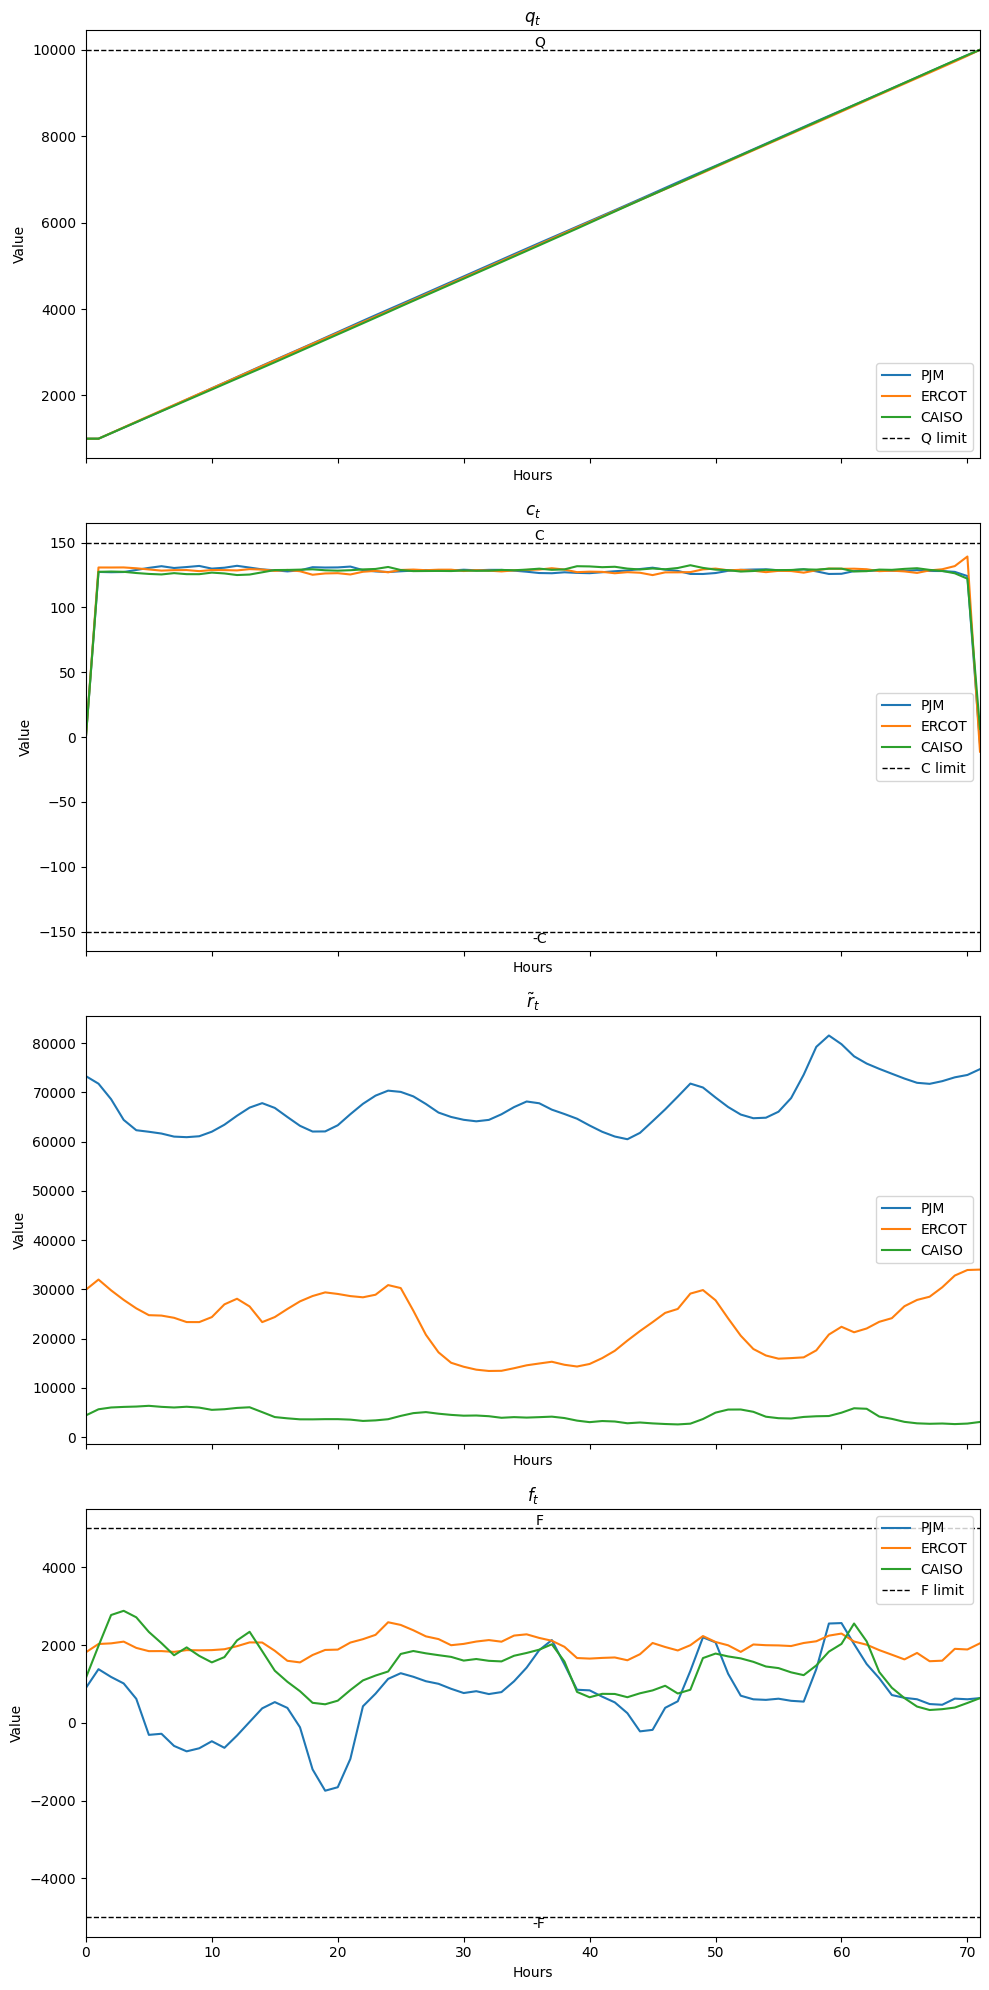

In [6]:
fig, axs = plt.subplots(4, 1, figsize=(10, 20), sharex=True)
labels = ["PJM", "ERCOT", "CAISO"]

for i in range(N):
    axs[0].plot(q[i, :], label=f"{labels[i]}")
    axs[1].plot(c[i, :], label=f"{labels[i]}")
    axs[2].plot(r_tilde[i, :], label=f"{labels[i]}")
    axs[3].plot(flow[i, :], label=f"{labels[i]}")

# Set limits and add horizontal lines with labels, positioned more centrally
for i, ax in enumerate(axs):
    mid_point = T // 2  # Calculate middle point of the x-axis
    if i == 0:  # State of charge subplot
        ax.axhline(Q[0], color='black', linestyle='--', linewidth=1, label='Q limit')
        ax.text(mid_point, Q[0], 'Q', verticalalignment='bottom', horizontalalignment='center')
    elif i == 1:  # Charge/discharge subplot
        ax.axhline(C[0], color='black', linestyle='--', linewidth=1, label='C limit')
        ax.axhline(-C[0], color='black', linestyle='--', linewidth=1)
        ax.text(mid_point, C[0], 'C', verticalalignment='bottom', horizontalalignment='center')
        ax.text(mid_point, -C[0], '-C', verticalalignment='top', horizontalalignment='center')
    elif i == 3:  # Flow subplot
        ax.axhline(F[0], color='black', linestyle='--', linewidth=1, label='F limit')
        ax.axhline(-F[0], color='black', linestyle='--', linewidth=1)
        ax.text(mid_point, F[0], 'F', verticalalignment='bottom', horizontalalignment='center')
        ax.text(mid_point, -F[0], '-F', verticalalignment='top', horizontalalignment='center')

axs[0].set_title(r'$q_t$')
axs[1].set_title(r'$c_t$')
axs[2].set_title(r'$\tilde r_t$')
axs[3].set_title(r'$f_t$')

for ax in axs:
    ax.legend()
    ax.set_xlabel('Hours')
    ax.set_ylabel('Value')
    ax.set_xlim([0, T - 1])

plt.tight_layout()
#plt.savefig('variable_plots.pdf')
plt.show()
